# **Importing libraries**

In [2]:
#model
import tensorflow as tf
from sklearn.model_selection import train_test_split

#nlp processing
import unicodedata
import re
import numpy as np


import warnings 
warnings.filterwarnings('ignore')


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **Data preprocessing**
**The basic text processing in NLP are:**
1. Sentence Segmentation
2. Normalization
3. Tokenization

## **Segmentation** 
formatting data to be in a question answer format

In [3]:
#reading data
data=open('/kaggle/input/simple-dialogs-for-chatbot/dialogs.txt','r').read()

In [4]:
#paried list of question and corresponding answer
QA_list=[QA.split('\t') for QA in data.split('\n')]
print(QA_list[:5])

[['hi, how are you doing?', "i'm fine. how about yourself?"], ["i'm fine. how about yourself?", "i'm pretty good. thanks for asking."], ["i'm pretty good. thanks for asking.", 'no problem. so how have you been?'], ['no problem. so how have you been?', "i've been great. what about you?"], ["i've been great. what about you?", "i've been good. i'm in school right now."]]


In [5]:
questions=[row[0] for row in QA_list]
answers=[row[1] for row in QA_list]

In [6]:
print(questions[0:5])
print(answers[0:5])

['hi, how are you doing?', "i'm fine. how about yourself?", "i'm pretty good. thanks for asking.", 'no problem. so how have you been?', "i've been great. what about you?"]
["i'm fine. how about yourself?", "i'm pretty good. thanks for asking.", 'no problem. so how have you been?', "i've been great. what about you?", "i've been good. i'm in school right now."]


## **Normalization**
To reduce its randomness, bringing it closer to a predefined “standard”

In [7]:
def remove_diacritic(text):
    return ''.join(char for char in unicodedata.normalize('NFD',text)
                  if unicodedata.category(char) !='Mn')

In [53]:
def preprocessing(text):
    
    #Case folding and removing extra whitespaces
    text=remove_diacritic(text.lower().strip())
    
    #Ensuring punctuation marks to be treated as tokens
    text=re.sub(r"([?.!,¿])", r" \1 ", text)
    
    #Removing redundant spaces
    text= re.sub(r'[" "]+', " ", text)
    
    #Removing non alphabetic characters
    text=re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)
    
    text=text.strip()
    
    #Indicating the start and end of each sentence
    text='<start> ' + text + ' <end>'
    
    return text

In [54]:
preprocessed_questions=[preprocessing(sen) for sen in questions]
preprocessed_answers=[preprocessing(sen) for sen in answers]

print(preprocessed_questions[0])
print(preprocessed_answers[0])

<start> hi , how are you doing ? <end>
<start> i m fine . how about yourself ? <end>


## **Tokenization**

In [55]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
    
    #build vocabulary on unique words 
    lang_tokenizer.fit_on_texts(lang)
    
    return lang_tokenizer

## **Word Embedding**
representing words in form of real-valued vetors

In [56]:
def vectorization(lang_tokenizer,lang):
    
    #word embedding for training the neural network
    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

    return tensor

## **Creating Dataset** 
for training and testing the model

In [57]:
def load_Dataset(data,size=None):
    
    if(size!=None):
        y,X=data[:size]
    else:
        y,X=data
        
    X_tokenizer=tokenize(X)
    y_tokenizer=tokenize(y)
    
    X_tensor=vectorization(X_tokenizer,X)
    y_tensor=vectorization(y_tokenizer,y)
    
    return  X_tensor,X_tokenizer, y_tensor, y_tokenizer

In [58]:
size=30000
data=preprocessed_answers,preprocessed_questions\

X_tensor,X_tokenizer, y_tensor, y_tokenizer=load_Dataset(data,size)

In [59]:
# Calculate max_length of the target tensors
max_length_y, max_length_X = y_tensor.shape[1], X_tensor.shape[1]

## **Splitting Data**
Creating training and validation sets using an 80-20 split after the required preprocessing is applied to the whole data


In [60]:
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2)

# Show length
print(len(X_train), len(y_train), len(X_val), len(y_val))

2980 2980 745 745


## **Tensorflow Dataset**

In [61]:
BUFFER_SIZE = len(X_train)
BATCH_SIZE = 64
steps_per_epoch = len(X_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(X_tokenizer.word_index)+1
vocab_tar_size = len(y_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 24]), TensorShape([64, 24]))

# **Model**

**Bahdanau Attention Mechanism**

https://machinelearningmastery.com/the-bahdanau-attention-mechanism/

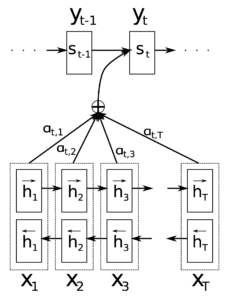

Adding attention mechanism to an Encoder-Decoder Model to make the model focus on specific parts of input sequence by assigning weights to different parts of the input sequence 


## **Buliding Model Architecture** 

#### **Encoder**

In [17]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [18]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 24, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


#### **Attention Mechanism**

In [19]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [20]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 24, 1)


#### **Decoder** 

In [21]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [22]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 2356)


## **Training Model**

1. Pass the input through the encoder which return encoder output and the encoder hidden state.
2. The encoder output, encoder hidden state and the decoder input (which is the start token) is passed to the decoder.
3. The decoder returns the predictions and the decoder hidden state.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use teacher forcing to decide the next input to the decoder.
6. Teacher forcing is the technique where the target word is passed as the next input to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [23]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [24]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([y_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [26]:
EPOCHS = 40

for epoch in range(1, EPOCHS + 1):
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

    if(epoch % 4 == 0):
        print('Epoch:{:3d} Loss:{:.4f}'.format(epoch,
                                          total_loss / steps_per_epoch))

Epoch:  4 Loss:1.5256
Epoch:  8 Loss:1.2739
Epoch: 12 Loss:1.1026
Epoch: 16 Loss:0.9474
Epoch: 20 Loss:0.7886
Epoch: 24 Loss:0.6198
Epoch: 28 Loss:0.4336
Epoch: 32 Loss:0.2459
Epoch: 36 Loss:0.1113
Epoch: 40 Loss:0.0499


## **Model Evaluation**

In [62]:
def remove_tags(sentence):
    return sentence.split("<start>")[-1].split("<end>")[0]

In [63]:
def evaluate(sentence):
    sentence = preprocessing(sentence)

    inputs = [X_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_X,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([y_tokenizer.word_index['<start>']], 0)

    for t in range(max_length_y):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += y_tokenizer.index_word[predicted_id] + ' '

        if y_tokenizer.index_word[predicted_id] == '<end>':
            return remove_tags(result), remove_tags(sentence)

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return remove_tags(result), remove_tags(sentence)

In [64]:
def ask(sentence):
    result, sentence = evaluate(sentence)

    print('Question: %s' % (sentence))
    print('Predicted answer: {}'.format(result))

In [70]:
ask(questions[1])

Question:  i m fine . how about yourself ? 
Predicted answer: that probably good life okay . 
